### 1. 인물모드 직접 해 보기

In [1]:
from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


In [2]:
## 해야 할 것: 먼저 사람이랑 동물 segment하고, 크로마키 합성하기

In [3]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt

(853, 1280, 3)


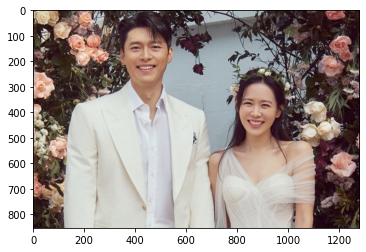

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/손예진.png'  
img_orig = cv2.imread(img_path) 
print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))  #이번에도 이미지 색상 채널 BGR -> RGB로 변경
plt.show()

In [5]:
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')  #PixelLib에서 제공해주는 모델
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 
urllib.request.urlretrieve(model_url, model_file) 
# urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x79185a5cf760>)

In [6]:
model = semantic_segmentation() 
model.load_pascalvoc_model(model_file) #이미 훈련된 모델을 로드하자

In [7]:
segvalues, output = model.segmentAsPascalvoc(img_path)

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

In [9]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [10]:
segvalues['masks'].shape #mask 크기는 원본 이미지 img_orig크기랑 같음

(853, 1280)

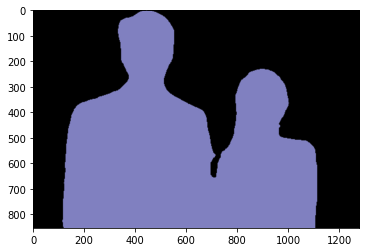

In [11]:
plt.imshow(output)
plt.show()  #잘 segment된 것을 볼 수 있다. 

In [12]:
#class_id를 알아보자!!!
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])  #배경, 사람으로만 이루어져 있음을 확인

background
person


In [13]:
#컬러맵 만들기

colormap = np.zeros((256, 3), dtype = int)  #RGB값으로 구성된 256개의 색상을 저장
ind = np.arange(256, dtype = int) #0~255까지의 정수 배열로, 각 인덱스의 색상을 생성

for shift in reversed(range(8)): #R, G,B에 대해 8비트 값을 생성함. 거꾸로 함. 그리고 shift는 7->0으로 감소하며 각 비트 영역 처리
    for channel in range(3): #0은 빨강, 1은 녹색, 2는 파랑
        colormap[:, channel] |= ((ind>>channel)&1) <<shift  #(ind >> channel) & 1 는 ind 배열의 각 값의 channel 위치에 있는 비트를 추출 후 shift위치로 이동
    ind >>=3
    
colormap[:20] #생성된 컬러맵의 첫 20개의 색상을 출력합니다. 이는 PASCAL VOC 데이터셋에서 자주 사용하는 색상입니다.


array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

- color맵은 색상이 각 객체 클래스에 대해 고유하게 정의되어 객체 분할 결과를 시각화한다. 예를 들어 배경을 분할할 때는 0: 검은색, 고양이를 분할할 때는 #8, dark red brown 으로 분류한다. 

In [14]:
colormap[15]  #이건 사람을 나타내는 색상으로, right grey 색상이다. 

array([192, 128, 128])

In [15]:
#colormap은 RGB, 우리의 output은 BGR

seg_color = (128, 128, 192)

(853, 1280)


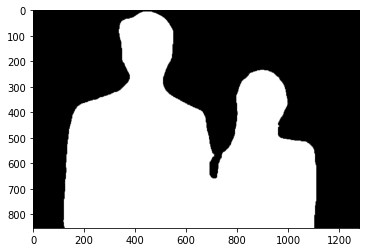

In [16]:
#seg_color로만 이루어진 마스크 만들기

seg_map = np.all(output ==seg_color, axis = -1) #axis =-1은 마지막 축을 기준. 따라서 이 코드는 RGB 채널을 따라 output 픽셀 값이 seg_color 인지 계속 확인
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

In [17]:
seg_map

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

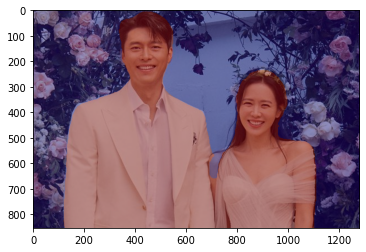

In [18]:
img_show = img_orig.copy() 
img_mask = seg_map.astype(np.uint8) * 255 #True는 255, False는 0
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET) #255와 0을 적당한 색상으로 바꾸기
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0) 
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

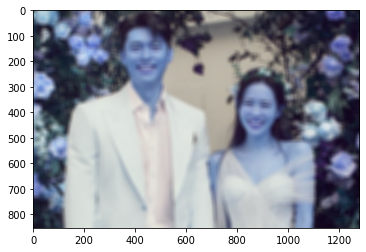

In [40]:
img_orig_blur = cv2.blur(img_orig, (20,20))  #배경은 더 흐릿하게 하고싶어
plt.imshow(img_orig_blur)
plt.show()

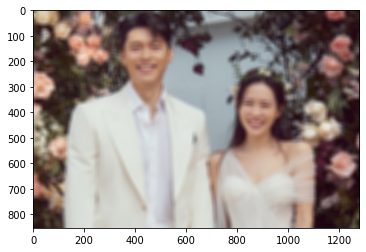

In [41]:
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

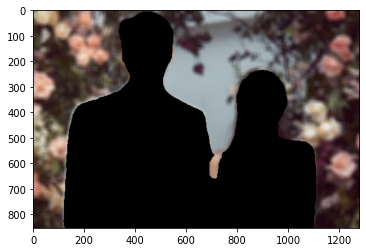

In [42]:
#배경만 추출하기
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR) 
img_bg_mask = cv2.bitwise_not(img_mask_color)  #이미지가 반전. 사람이 255, 배경이 0인데 반전됨
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask) #블러 이미지랑 마스크랑 합치면 사람은 0이었으니까 사람은 사라지고 배경만 남음
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

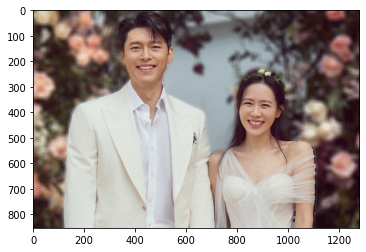

In [43]:
#이제 배경 영상과 사람 영상을 합쳐보자!!!!

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur) #마스크컬러가 255면 (사람), 원래 이미지, 아닌 곳은 블러배경
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### **크로마키 합성**

In [19]:
background_path = os.path.join(os.getenv('HOME'), 'aiffel/human_segmentation/images/배경.jpg')
segvalues_bg, output_bg = model.segmentAsPascalvoc(background_path)

In [22]:
background_orig = cv2.imread(background_path)

In [23]:
segvalues_bg

{'class_ids': array([0]), 'masks': False}

In [24]:
colormap[0]  #[0,0,0]이므로 완전 다 배경으로 인식

array([0, 0, 0])

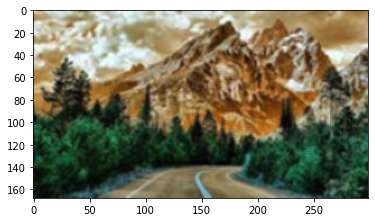

In [45]:
background_orig_blur = cv2.blur(background_orig, (3,3))  #배경은 더 흐릿하게 하고싶어
plt.imshow(background_orig_blur)
plt.show()

(853, 1280, 3)


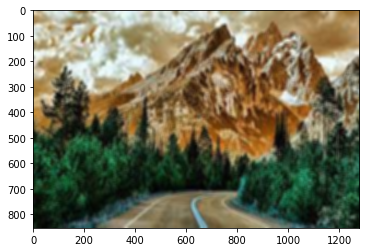

In [46]:
background_orig_blur = cv2.resize(background_orig_blur, dsize = (1280, 853)) #합성하기 전에 먼저 사이즈부터 맞춰놓기
print(background_orig_blur.shape)
plt.imshow(background_orig_blur)
plt.show()

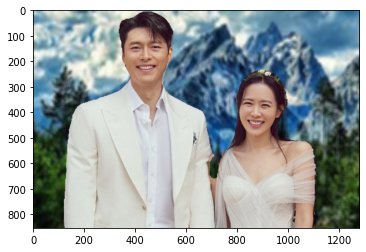

In [47]:
cromaky = np.where(img_mask_color==255, img_orig, background_orig_blur) #마스크컬러가 255면 (사람), 원래 이미지, 아닌 곳은 블러배경
plt.imshow(cv2.cvtColor(cromaky, cv2.COLOR_BGR2RGB))
plt.show()

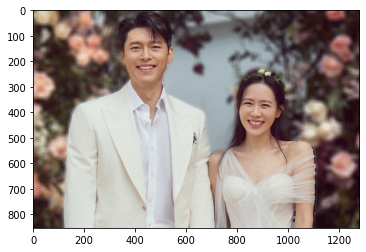

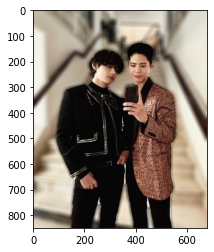

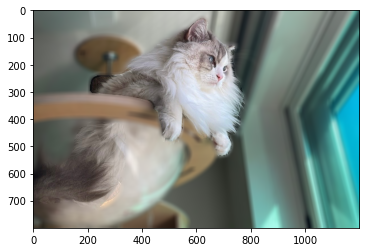

In [48]:
import os
import urllib.request
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pixellib.semantic import semantic_segmentation

# 파일 경로 설정
image_paths = [
    os.path.join(os.getenv('HOME'), 'aiffel/human_segmentation/images/손예진.png'),
    os.path.join(os.getenv('HOME'), 'aiffel/human_segmentation/images/박보검.jpg'),
    os.path.join(os.getenv('HOME'), 'aiffel/human_segmentation/images/cat1.jpg')
]

model_dir = os.path.join(os.getenv('HOME'), 'aiffel/human_segmentation/models')
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 모델 파일 다운로드
if not os.path.exists(model_file):
    urllib.request.urlretrieve(model_url, model_file)

# 모델 로드
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

# 컬러맵 초기화
colormap = np.zeros((256, 3), dtype=int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

# 이미지 처리
for path in image_paths:
    img_path = path
    img_orig = cv2.imread(img_path)

    segvalues, output = model.segmentAsPascalvoc(img_path)

    seg_color = None
    for object_num, class_id in enumerate(segvalues['class_ids']):
        if class_id == 8 or class_id == 15:
            b, g, r = colormap[class_id]
            seg_color = (r, g, b)
            break

    if seg_color is not None:
        seg_map = np.all(output == seg_color, axis=-1)
        img_mask = seg_map.astype(np.uint8) * 255
        color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
        img_show = cv2.addWeighted(img_orig, 0.6, color_mask, 0.4, 0.0)
        img_orig_blur = cv2.blur(img_orig, (20, 20))
        img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
        img_bg_mask = cv2.bitwise_not(img_mask_color)
        img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
        img_concat = np.where(img_mask_color == 255, img_orig, img_bg_blur)
        plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
        plt.show()


### 2. 사진에서 문제점 찾기

![nn](손예진현빈.png)

![nn](박보검방탄.png)

![nn](냐옹이.png)

#### 고양이 원래 사진 (비교를 위해)

![nn](cat1.jpg)

- **위 사진들에서 파란 선 친 부분, 즉 사람과 배경의 경계선 처리가 뚜렷하지 않고 흐릿하다.** 
- **고양이의 경우도 마찬가지로, 물체 속에 담긴 부분의 몸통 쪽의 경계가 흐릿하다.**

### 3. 해결방법을 제안해보기

- Segment Anything Model (SAM) 사용:  
    Meta에서 제안한 것. 1100만 개의 이미지와 11억 개의 마스크로 구성된 데이터셋으로 학습되었으며, 다양한 segmentation task에서 강력한 zero-shot 성능을 보인다. 광범위한 대용량 데이터셋을 학습시켜서 generalization 능력이 엄청나다.   
    여기서 zero-shot 성능은 모델이 훈련 데이터에 없는 클래스나 레이블을 예측하는 능력을 의미한다. 
    
- Pytorch 를 다운받아 오려고 했는데 너무 늦어서 일단 https://segment-anything.com/demo# 에서 데모를 실행해보았다. 

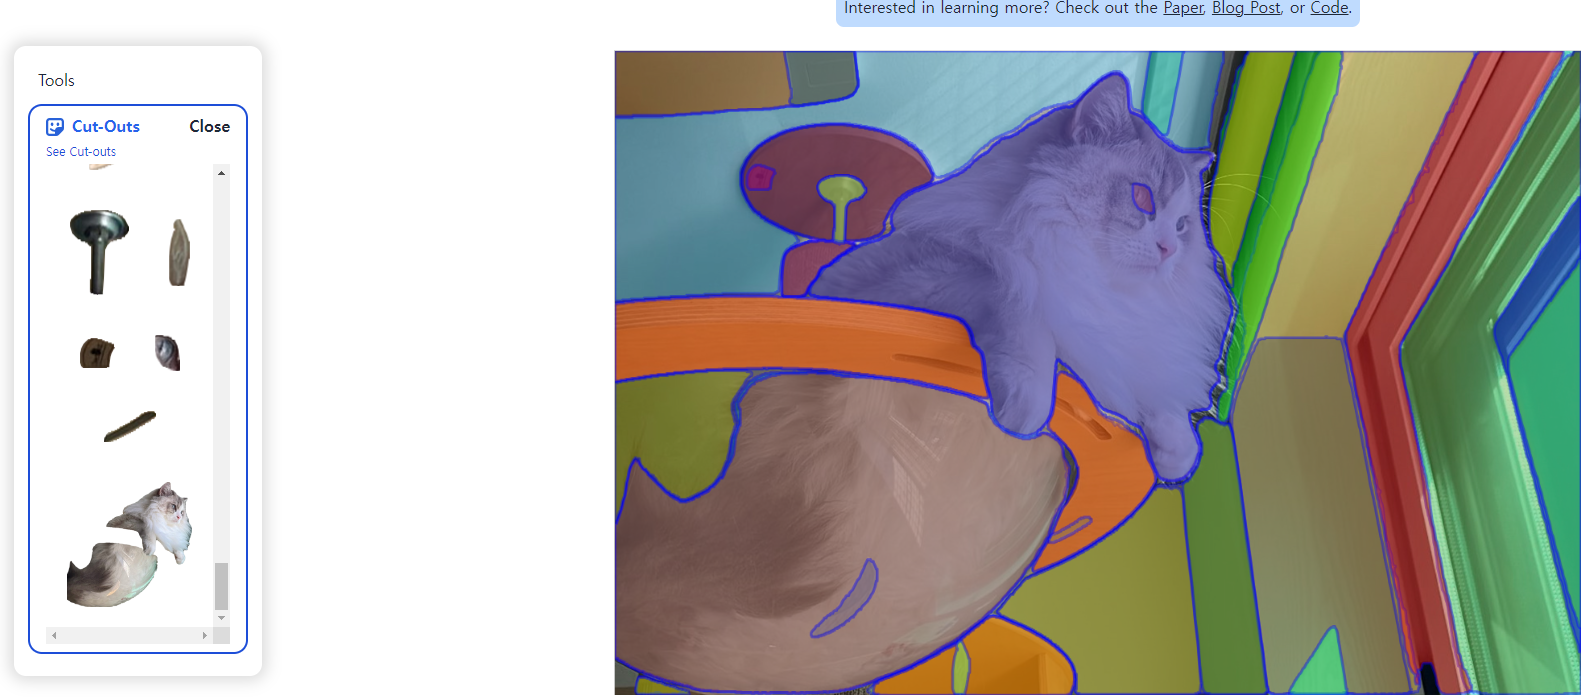

- 확실히 기존 DeepLab V3+ 보다 더 깔끔한 성능을 보인다. 

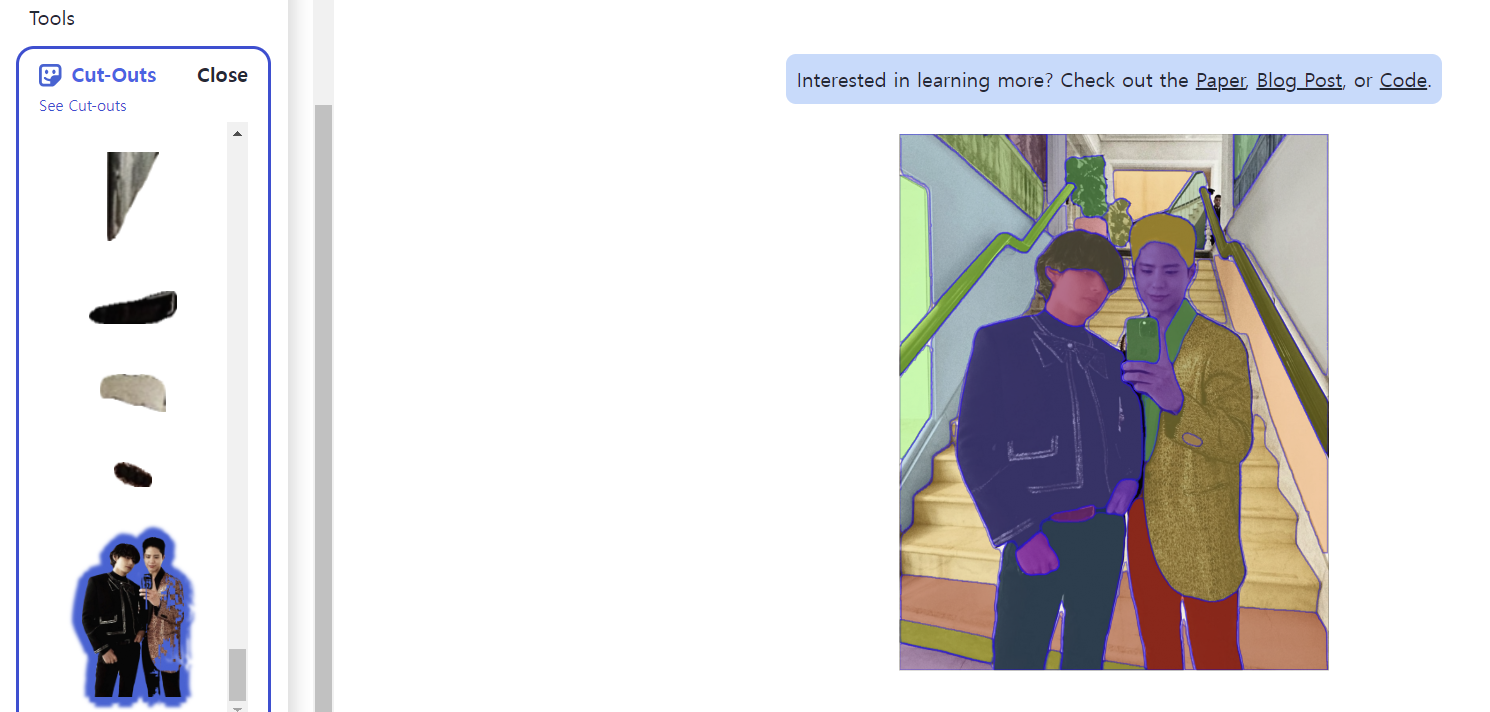

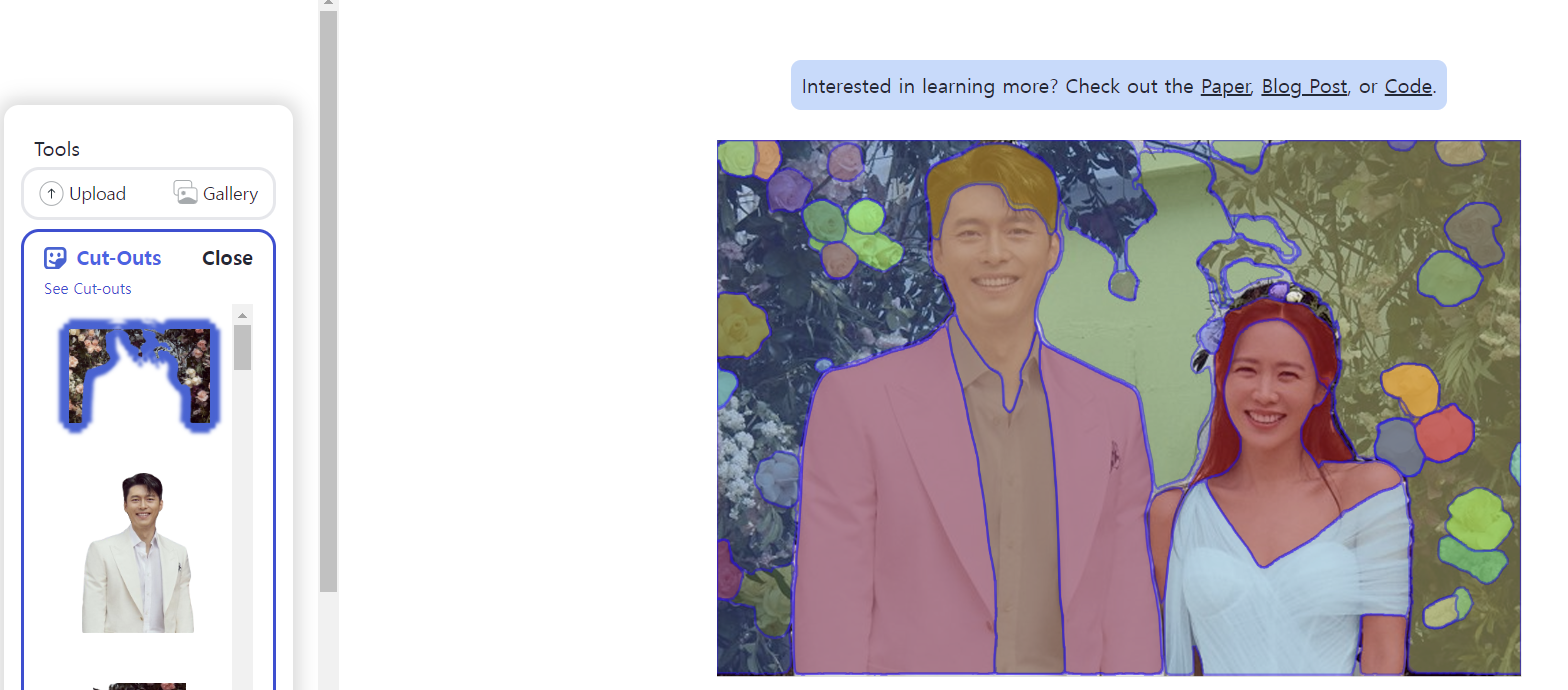

### 4. 회고

- 맨날 구글밋이나 줌에서 해 보던 배경 블러 처리가 이런 원리인 거 같아서 신기했다. 일단 물체랑 배경을 따로 인식하고, 배경을 블러처리해서 합성하는 원리!!
- 엄청 refined된 모델로 구성된 DeepLab v3+도 좋지만, 대용량의 prompt encoder와 image encoder로 학습된 SAM 성능이 확실히 좋아졌다. 
- 시간이 없어서 직접 파이토치 불러와서 해보지는 못했다. 수업 끝나고 해봐야지..